In [97]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import pprint

pprint.pprint(plt.style.available)
plt.style.use(
    "seaborn-whitegrid"
)
plt.rcParams["figure.figsize"] = (15, 8)

['Solarize_Light2',
 '_classic_test_patch',
 '_mpl-gallery',
 '_mpl-gallery-nogrid',
 'bmh',
 'classic',
 'dark_background',
 'fast',
 'fivethirtyeight',
 'ggplot',
 'grayscale',
 'seaborn',
 'seaborn-bright',
 'seaborn-colorblind',
 'seaborn-dark',
 'seaborn-dark-palette',
 'seaborn-darkgrid',
 'seaborn-deep',
 'seaborn-muted',
 'seaborn-notebook',
 'seaborn-paper',
 'seaborn-pastel',
 'seaborn-poster',
 'seaborn-talk',
 'seaborn-ticks',
 'seaborn-white',
 'seaborn-whitegrid',
 'tableau-colorblind10']


In [98]:
dfs = []
shapes = []
for dirname, _, filenames in os.walk('./data'):
    for filename in filenames:
        
        # the gearbox state is in the filename prefix (h = healthy, b = broken tooth)
        state = filename[0]
        
        # the load is in the filename suffix
        load = int(filename.split('.')[0][5:])
        
        # read in the file
        df = pd.read_csv(os.path.join(dirname, filename))
        
        # include the healthy/broken state
        df['state'] = state
        
        # include the load
        df['load'] = load 
        df = df[:88320]
        # append to a list
        shapes = shapes + [df.shape]
        dfs.append(df)


# concatenate all the datasets and reset the index
df = pd.concat(dfs).reset_index().rename(columns={'index':'sample_index'})
df = df.reset_index().drop(["index"], axis = 1)

In [99]:
pprint.pprint(min(shapes))


(88320, 6)


In [100]:
df.head()

sample_index        a1        a2        a3        a4 state  load
0             0  2.350390  1.454870 -1.667080 -2.055610     b     0
1             1  2.452970  1.400100 -2.825100  0.984487     b     0
2             2 -0.241284 -0.267390  0.793540  0.605862     b     0
3             3  1.130270 -0.890918  0.696969  0.613068     b     0
4             4 -1.296140  0.980479 -1.130560 -0.346971     b     0

In [101]:
df.shape

(1766400, 7)

In [102]:
## 4.1
def FFT(data):
    col = data.columns.values
    df_fft = np.fft.fft(data, axis = 0)
    abs_df = pd.DataFrame(abs(df_fft), columns= col)
    
    return abs_df

In [103]:
## 4.2
def Concate_features(x):
    index_list = ["A" + str(n) for n in np.arange(1,5)]
    dff = pd.DataFrame({})
    for index in index_list:

        xx = x.loc[[index]]
        col = [index + "_" + "F" + str(n) for n in np.arange(1,16)]
        xx.columns = col 
        xx = xx.reset_index().drop(["index"], axis = 1)
        dff = pd.concat([dff, xx], axis = 1)
    return dff

In [104]:
def RMS(data):
    
    col = ["F"+ str(n) for n in np.arange(1,16)]
    
    x = data[0:10]
    x = x.applymap(lambda a : a**2)
    x = pd.DataFrame((x.sum()/10),columns=["F1"]).applymap(lambda a : math.sqrt(a))

    for n in np.arange(1,15):
        y = data[n*0:(n+1)*10]
        y = y.applymap(lambda a : a**2)
        y = pd.DataFrame((y.sum()/10) , columns= [col[n]]).applymap(lambda a : math.sqrt(a))
        x = pd.concat([x, y], axis = 1)
    
    df = Concate_features(x)
    return df

In [105]:
def Feature_create(data):
    df = pd.DataFrame({})
    for load in np.linspace(0,90,10):
        dff = data[data["Load_percent"] == load ]
        X = dff[['A1', 'A2', 'A3', 'A4']]
        for n in range(290):
            time_domain = X[n*300:(n+1)*300]
            freq_domain = FFT(time_domain)
            f = freq_domain[0:150]
            f = RMS(f)
            
            df = pd.concat([df, f], axis = 0 )
            
    return df 

Visualize the data with graph

In [118]:
import seaborn as sns

test_df = df[df["load"] == 0]
test_df_h = test_df[test_df["state"] == "h"][:1000]
test_df_b = test_df[test_df["state"] == "b"][:1000]
test_df = pd.concat([test_df_h, test_df_b], axis = 0)
test_df = test_df.reset_index().drop(["index"], axis = 1)
test_df.rename(columns={"a1": "A1", "a2":"A2", 
                        "a3":"A3", "a4":"A4",}, inplace=True)
# test_df.drop(["sample_index"], axis = 1, inplace=True)
test_df.tail()

sample_index        A1        A2       A3       A4 state  load
1995           995  4.581470 -0.407461 -0.52899 -2.24349     b     0
1996           996  3.146960  2.227520 -0.50264 -2.30806     b     0
1997           997  3.434750  4.754170 -1.78579 -4.28651     b     0
1998           998  1.393980  2.785290 -2.13151 -3.61948     b     0
1999           999 -0.813013 -1.259710 -1.29728 -1.70301     b     0

In [119]:
test_df["state"] = test_df["state"].astype("category")
test_df[["sample_index","A1", "A2", "A3", "A4"]] = np.float32(test_df[["sample_index","A1", "A2", "A3", "A4"]])
test_df["load"] = test_df["load"].astype("int8")

In [120]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   sample_index  2000 non-null   float32 
 1   A1            2000 non-null   float32 
 2   A2            2000 non-null   float32 
 3   A3            2000 non-null   float32 
 4   A4            2000 non-null   float32 
 5   state         2000 non-null   category
 6   load          2000 non-null   int8    
dtypes: category(1), float32(5), int8(1)
memory usage: 43.2 KB


In [121]:
test_df.tail()

sample_index        A1        A2       A3       A4 state  load
1995         995.0  4.581470 -0.407461 -0.52899 -2.24349     b     0
1996         996.0  3.146960  2.227520 -0.50264 -2.30806     b     0
1997         997.0  3.434750  4.754170 -1.78579 -4.28651     b     0
1998         998.0  1.393980  2.785290 -2.13151 -3.61948     b     0
1999         999.0 -0.813013 -1.259710 -1.29728 -1.70301     b     0

Text(0.5, 1.0, 'Broken')

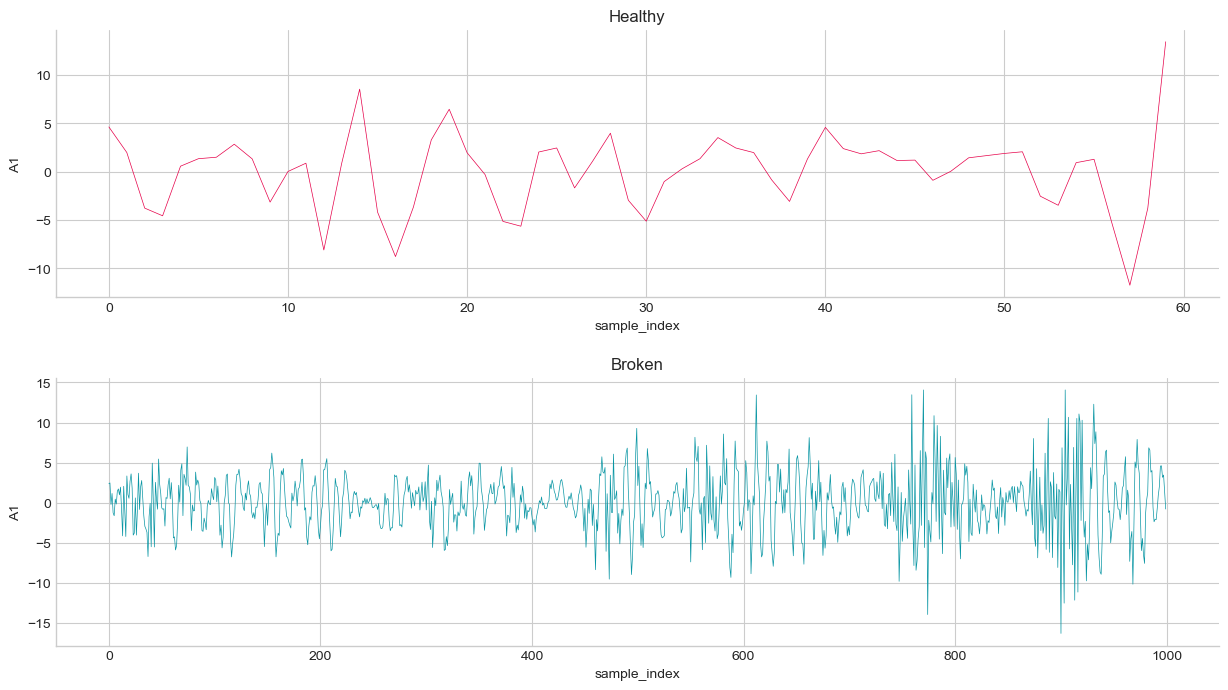

In [15]:
# sns.lineplot(
#     data=test_df, x="sample_index", y="A1", hue="state", dashes=False, legend="full", size=0.1
# )

plt.style.use(
    "D:\ObsidianBlog\BlogArticles\VSCODE\itzk.mplstyle"
)
cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']

# subplot  both graph in same image
fig, (ax1, ax2)  = plt.subplots(2, 1, figsize=(15, 8))
fig.subplots_adjust(hspace=.3)


ax1.plot(test_df.sample_index.where(test_df.state == "h")[:60], test_df.A1.where(test_df.state == "h")[:60], label="healthy", color= cycle[0], linewidth=0.5)
ax1.set_xlabel("sample_index")
ax1.set_ylabel("A1")
ax1.set_title("Healthy")
# ax1.plot(test_df["sample_index"], test_df["A2"], label="A2")


ax2.plot(test_df.sample_index.where(test_df.state == "b"), test_df.A1.where(test_df.state == "b"), label="healthy", color=cycle[1], linewidth=0.5)
ax2.set_xlabel("sample_index")
ax2.set_ylabel("A1")
ax2.set_title("Broken")
